In [1]:
!pip install --quiet umap-learn

In [2]:
import pandas as pd

ANGLE = '/kaggle/input/exercise-detection-dataset/exercise_angles.csv'


df = pd.read_csv(filepath_or_buffer=ANGLE).drop(columns=['Side'])
df.head()

,Shoulder_Angle,Elbow_Angle,Hip_Angle,Knee_Angle,Ankle_Angle,Shoulder_Ground_Angle,Elbow_Ground_Angle,Hip_Ground_Angle,Knee_Ground_Angle,Ankle_Ground_Angle,Label
0,10.639208,174.466813,174.785143,179.848140,179.419276,90.0,90.0,90.0,90.0,90.0,Jumping Jacks
1,10.590342,174.428706,174.765042,179.775215,179.386147,90.0,90.0,90.0,90.0,90.0,Jumping Jacks
2,10.546746,174.489431,174.785790,179.660017,179.333710,90.0,90.0,90.0,90.0,90.0,Jumping Jacks
3,10.487682,174.614913,174.759542,179.614223,179.313926,90.0,90.0,90.0,90.0,90.0,Jumping Jacks
4,10.412107,174.758503,174.737721,179.570564,179.298805,90.0,90.0,90.0,90.0,90.0,Jumping Jacks


The Side column only contains the value 'left' so we can drop it.

Are our classes balanced?

In [3]:
df['Label'].value_counts().to_dict()

{'Push Ups': 9764,
 'Pull ups': 6659,
 'Jumping Jacks': 5209,
 'Squats': 4997,
 'Russian twists': 4404}

In [4]:
from plotly import express
express.histogram(data_frame=df['Label'].value_counts().to_frame().reset_index(), x='Label', y='count')

No, our classes are not balanced. They're not terribly unbalanced, but they're definitely not balanced.

Let's use dimension reduction to build a scatter plot of our data; we'll use [sklearn TSNE](https://scikit-learn.org/0.16/modules/generated/sklearn.manifold.TSNE.html) because using UMAP will require us to install another package.

In [5]:
import arrow
from umap import UMAP

COLUMNS = ['Shoulder_Angle', 'Elbow_Angle', 'Hip_Angle', 'Knee_Angle', 'Ankle_Angle', 'Shoulder_Ground_Angle', 'Elbow_Ground_Angle', 'Hip_Ground_Angle', 'Knee_Ground_Angle', 'Ankle_Ground_Angle']
time_start = arrow.now()
reducer = UMAP(random_state=2024, verbose=False, n_jobs=1, low_memory=False, n_epochs=201)
df[['x', 'y']] = reducer.fit_transform(X=df[COLUMNS])
print('done with UMAP in {}'.format(arrow.now() - time_start))

/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



done with UMAP in 0:01:00.655598


We're going to plot all the data, all 30k rows, so let's use a static plot.

<Axes: xlabel='x', ylabel='y'>

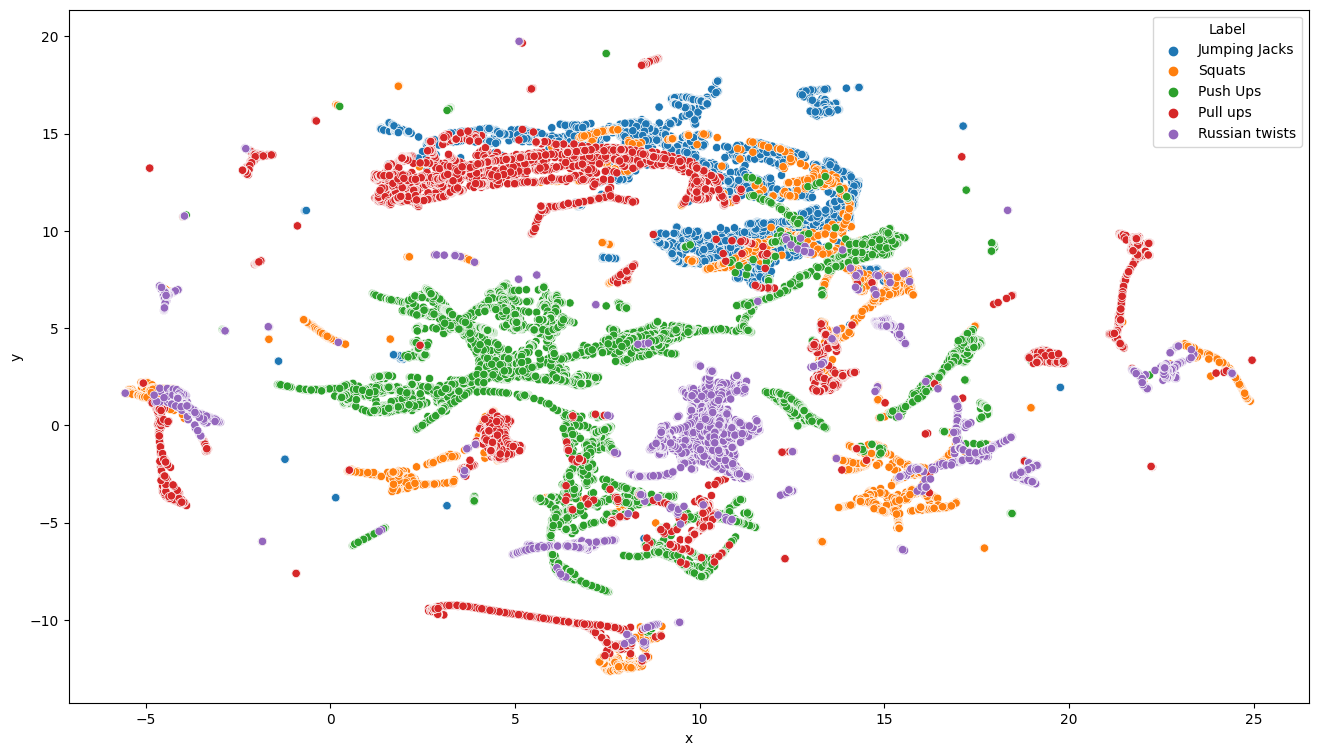

In [6]:
from seaborn import scatterplot
from matplotlib.pyplot import subplots

fig, ax = subplots(figsize=(16, 9))
scatterplot(ax=ax, data=df, x='x', y='y', hue='Label',)

What do we see? We see a lot of local clustering within an exercise type, even though each exercise type has multiple clusters and there are some hard cases, where an instance of one exercise type may have several close neighbors of other exercise types. This suggests we can build a reasonably accurate model. Let's find out.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split


# we want to be careful to not include the TSNE output columns in our model input, and to stratify according to the target variable
X_train, X_test, y_train, y_test = train_test_split(df[COLUMNS], df['Label'], test_size=0.2, random_state=2024, stratify=df['Label'])

logreg = LogisticRegression(max_iter=2000, tol=1e-4).fit(X_train, y_train)
print('model fit in {} iterations'.format(logreg.n_iter_[0]))
print('accuracy: {:5.4f} f1: {:5.4f}'.format(accuracy_score(y_true=y_test, y_pred=logreg.predict(X=X_test)), f1_score(average='weighted', y_true=y_test, y_pred=logreg.predict(X=X_test), zero_division=0)))
print(classification_report(y_true=y_test, y_pred=logreg.predict(X=X_test), zero_division=0))

model fit in 1935 iterations
accuracy: 0.6887 f1: 0.6882
                precision    recall  f1-score   support

 Jumping Jacks       0.53      0.63      0.58      1042
      Pull ups       0.49      0.45      0.47      1332
      Push Ups       0.90      0.87      0.89      1953
Russian twists       0.82      0.88      0.85       881
        Squats       0.60      0.54      0.57       999

      accuracy                           0.69      6207
     macro avg       0.67      0.67      0.67      6207
  weighted avg       0.69      0.69      0.69      6207



This is kind of disappointing; our model does reasonably well for pushups and Russian twists, but not so well for the other excercises. 

In [8]:
from plotly import express

express.histogram(x=COLUMNS, y=logreg.coef_[0])

Ah. Maybe this explains why we're having trouble: our logistic regression model is relying mostly on two features.

Can we do any better with KNN?

In [9]:
from sklearn.neighbors import KNeighborsClassifier

knn =  KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
print('accuracy: {:5.4f} f1: {:5.4f}'.format(accuracy_score(y_true=y_test, y_pred=knn.predict(X=X_test)), f1_score(average='weighted', y_true=y_test, y_pred=knn.predict(X=X_test), zero_division=0)))
print(classification_report(y_true=y_test, y_pred=knn.predict(X=X_test), zero_division=0))

accuracy: 0.9671 f1: 0.9671
                precision    recall  f1-score   support

 Jumping Jacks       0.97      0.97      0.97      1042
      Pull ups       0.96      0.96      0.96      1332
      Push Ups       0.98      0.99      0.99      1953
Russian twists       0.97      0.96      0.97       881
        Squats       0.94      0.94      0.94       999

      accuracy                           0.97      6207
     macro avg       0.96      0.96      0.96      6207
  weighted avg       0.97      0.97      0.97      6207



Yes, we can do a lot better with KNN.

We don't have a lot of KNN errors, so let's take a look at them. First let's build a DataFrame of all of the model probabilities.

In [10]:
probabilities_df = pd.DataFrame(data=knn.predict_proba(X=X_test), columns=['Jumping Jacks', 'Pull ups', 'Push ups', 'Russian twists', 'Squats']).reset_index().drop(columns=['index'])
probabilities_df['probability'] = probabilities_df.max(axis=1)
probabilities_df['true'] = y_test.tolist()
probabilities_df['pred'] = knn.predict(X=X_test)
probabilities_df['correct'] = probabilities_df['true'] == probabilities_df['pred']
probabilities_df[['x', 'y']] = reducer.transform(X=X_test)

probabilities_df.head()

,Jumping Jacks,Pull ups,Push ups,Russian twists,Squats,probability,true,pred,correct,x,y
0,0.0,1.0,0.0,0.0,0.0,1.0,Pull ups,Pull ups,True,4.155719,-9.424431
1,0.0,1.0,0.0,0.0,0.0,1.0,Pull ups,Pull ups,True,-2.016879,8.321489
2,1.0,0.0,0.0,0.0,0.0,1.0,Jumping Jacks,Jumping Jacks,True,12.241319,14.189927
3,0.0,0.0,1.0,0.0,0.0,1.0,Push Ups,Push Ups,True,9.508115,-7.025233
4,0.0,0.0,1.0,0.0,0.0,1.0,Push Ups,Push Ups,True,11.838601,1.706567


What does the mean model probability look like conditioned on whether the model prediction is correct?

In [11]:
probabilities_df[['probability', 'correct']].groupby(by=['correct']).mean().to_dict()

{'probability': {False: 0.7761437908496731, True: 0.9867843855849854}}

The good news is that when our model is correct the model probability is generally high; unfortunately it is also high when the model prediction is incorrect. This is partly a byproduct of the fact that the model probability can only take on four values: 0, 1/3, 2/3, and 1.

Now let's look at just the errors, where the model has misclassified the instance.

In [12]:
error_df = probabilities_df[probabilities_df['true'] != probabilities_df['pred']]
error_df.head()

,Jumping Jacks,Pull ups,Push ups,Russian twists,Squats,probability,true,pred,correct,x,y
14,0.666667,0.000000,0.000000,0.000000,0.333333,0.666667,Squats,Jumping Jacks,False,12.483947,13.789720
44,0.000000,0.000000,0.666667,0.000000,0.333333,0.666667,Squats,Push Ups,False,11.996381,9.457060
65,0.000000,0.333333,0.000000,0.000000,0.666667,0.666667,Pull ups,Squats,False,4.638738,-1.291722
105,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,Russian twists,Squats,False,-4.093688,1.882618
124,0.000000,0.000000,0.666667,0.333333,0.000000,0.666667,Russian twists,Push Ups,False,10.804399,-4.804933


When our model gets something wrong, what is the true value?

In [13]:
from plotly import express
express.histogram(data_frame=error_df, x='true')

When our model gets something wrong, what does it think it is?

In [14]:
express.histogram(data_frame=error_df, x='pred')

<Axes: xlabel='pred', ylabel='true'>

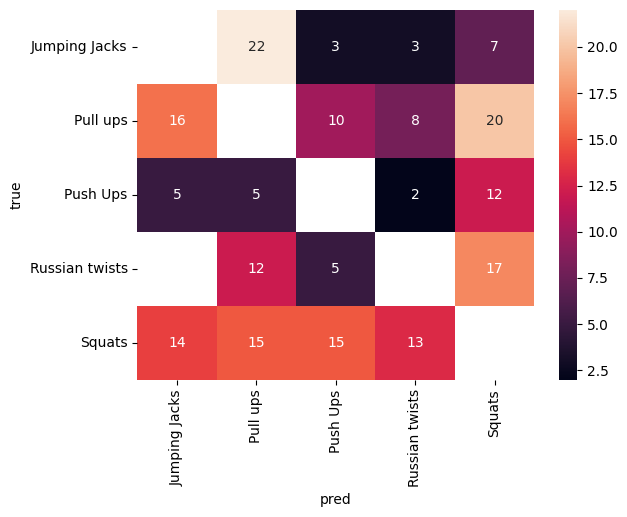

In [15]:
from seaborn import heatmap
heatmap(data=error_df[['true', 'pred']].groupby(by=['true', 'pred']).size().reset_index().pivot(values=0, index='true', columns='pred'), annot=True)

How often is our model probability low when the model prediction is correct? How often is the model probability high when the prediction is incorrect? Let's take a look.

In [16]:
express.scatter(data_frame=probabilities_df, x='x', y='y', color='probability', facet_col='correct', hover_name='true')